In [63]:
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.features import shapes, rasterize
from rasterio.plot import show
from shapely.geometry import shape
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
path = '/Users/rmason/Research/EnMAP/'

metafile = 'tile_13/ENMAP01-____L2A-DT0000012805_20230411T164842Z_001_V010400_20230928T061751Z-METADATA.XML'

cube = 'tile_13/ENMAP01-____L2A-DT0000012805_20230411T164842Z_001_V010400_20230928T061751Z-SPECTRAL_IMAGE.TIF'

#subset of Montefiore pits that are in tile 13, plus some that I identified by hand
pits = f'{path}manure_storage_structures/tile13_outlines.shp'


In [3]:
#Read the tile 13 pit outlines as polygons so we can get their areas, then
#use their centroids as point coords from which spectra will be extracted

polygons = gpd.read_file(pits).drop(columns=['id'])
points = gpd.GeoDataFrame(geometry=polygons['geometry'].centroid)
for column in polygons.columns:
    if column != 'geometry':
        points[column] = polygons[column]
points['Area (m2)'] = polygons.geometry.area.round(decimals=0).astype(int)

In [4]:
#Get the tile 13 EnMAP data

src = rasterio.open(path+cube)
img = src.read()

<Axes: >

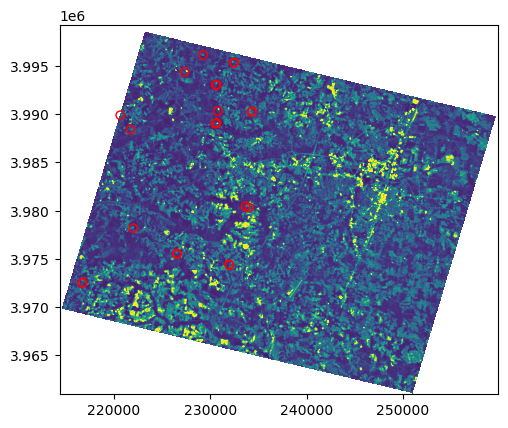

In [5]:
#Overplot the pits onto the EnMAP data cube

fig, ax = plt.subplots()
rasterio.plot.show(src, ax=ax, vmin=0, vmax=1000)
points.plot(ax=ax, color='r', facecolor='none')

In [6]:
#Insert the EnMAP spectrum of each pit centroid pixel into the point coordinate dataframe

coord_list = [(x, y) for x, y in zip(points["geometry"].x, points["geometry"].y)]
points["value"] = [x for x in src.sample(coord_list)]

In [7]:
#Get wavelength info from XML file

wavelengths = []
tree = ET.parse(path+metafile)
root = tree.getroot()
for child in root[3][-5]:
    bandWav = child[0].text
    wavelengths.append(float(bandWav))


In [8]:
#Some light editing:
# -- set regions badly affected by H2O to NaN
# -- change the order of the spectra in the df, for ease of interpretation

wavelengths = [w if (w < 1342 or w > 1391) else np.nan for w in wavelengths]
wavelengths = [w if (w < 1800 or w > 1950) else np.nan for w in wavelengths]

points.sort_values(by=['Color', 'Area (m2)'], ascending=False, inplace=True)
points.reset_index(inplace=True)

#preserve the original QGIS index so it's easier to find specific pits in QGIS
points.rename(columns={'index': 'QGIS ID'}, inplace=True)
points['QGIS ID'] = points['QGIS ID'] + 1

display(points)

,QGIS ID,geometry,Color,Comments,Source,Area (m2),value
0,8,POINT (226574.500 3975574.865),Green,1 of 2,Montefiore,5606,"[247, 232, 201, 230, 255, 249, 258, 262, 266, ..."
1,12,POINT (231956.115 3974432.628),Green,Disused?,Montefiore,2569,"[287, 275, 261, 277, 286, 291, 298, 310, 323, ..."
2,22,POINT (230589.778 3989034.649),Green,2 of 3,Extra,2202,"[215, 206, 203, 225, 227, 217, 217, 241, 250, ..."
3,13,POINT (231996.515 3974355.202),Green,Disused?,Montefiore,2048,"[281, 240, 253, 254, 259, 270, 277, 294, 287, ..."
4,9,POINT (226559.719 3975495.061),Green,2 of 2,Montefiore,1357,"[209, 193, 171, 209, 225, 207, 210, 231, 242, ..."
5,4,POINT (234357.851 3990291.696),Green,2 of 2,Montefiore,759,"[277, 247, 245, 256, 263, 268, 269, 282, 283, ..."
6,5,POINT (220676.220 3989901.451),Brown,1 of 3,Montefiore,13514,"[227, 223, 210, 248, 242, 249, 260, 269, 263, ..."
7,6,POINT (221733.574 3988409.427),Brown,1 of 3,Montefiore,9213,"[260, 239, 238, 259, 257, 241, 261, 267, 273, ..."
8,1,POINT (230585.659 3993025.014),Brown,1 of 2,Montefiore,8538,"[261, 238, 236, 258, 229, 229, 240, 264, 255, ..."
9,16,POINT (229269.522 3996156.978),Blue-green,None,Extra,15163,"[148, 109, 97, 103, 118, 115, 140, 162, 141, 1..."


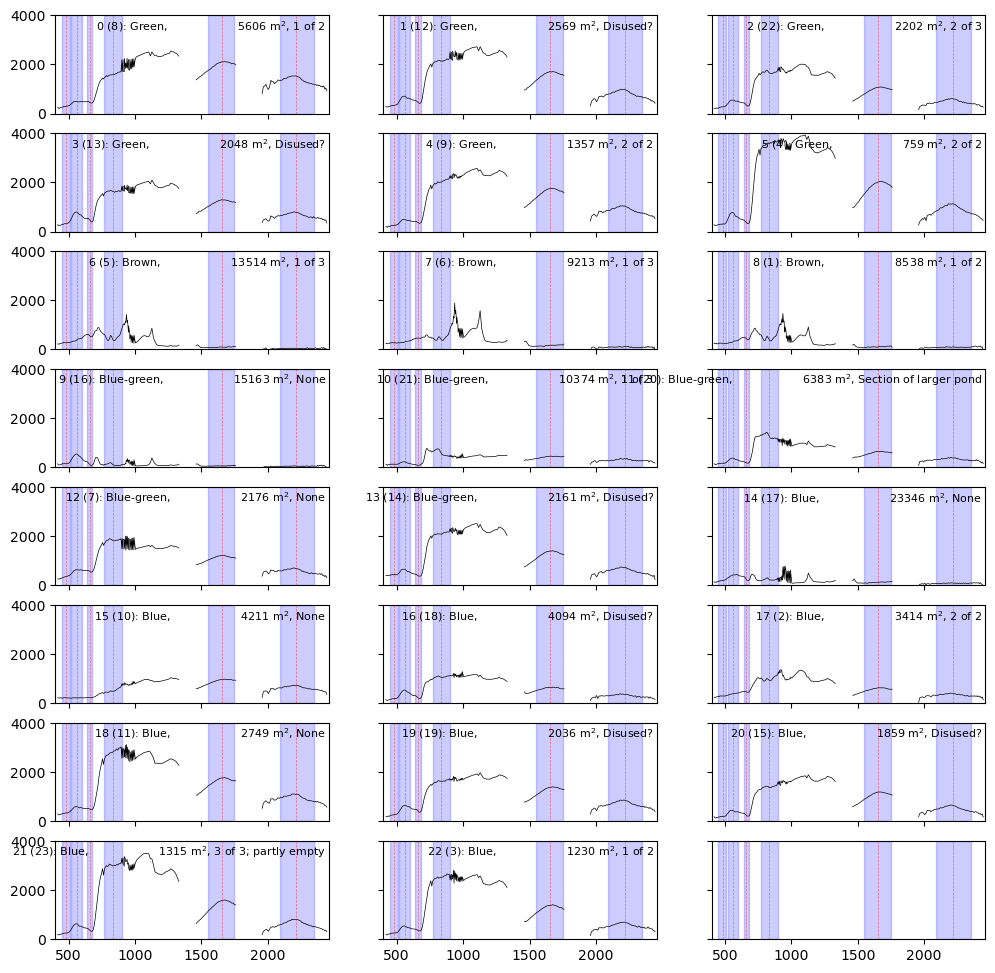

In [100]:
def plot_spectra(df, rows, cols, show_bands=None, ymax=4000):
    _, axes = plt.subplots(rows, cols, sharex='all', sharey='all', figsize=(12, 12))

    for row in range(rows):
        col = row * cols
        for ax in axes[row]:
            try:
                ax.plot(wavelengths, df['value'][col], color='k', lw=0.5)
            except KeyError:
                pass
            if show_bands is not None:
                for band in show_bands:
                    ax.axvline(wavelengths[band], color='r', ls='--', lw=0.5, alpha=0.5)
            #add APPROXIMATE Landsat bands
            for bandedges in [(450,510), (520,600), (640,680), (770,900), (1550,1750), (2090,2350)]:
                ax.fill_between(bandedges, 0, 1, color='b', alpha=0.2, zorder=0,\
                                transform=ax.get_xaxis_transform())
            #add info
            try:
                if 'Color' in df.columns:
                    str = f"{df.index[col]} ({df['QGIS ID'][col]}): {df['Color'][col]},\
                    {df['Area (m2)'][col]} m$^2$, {df['Comments'][col]}"
                else:
                    str = ""
                ax.text(x=0.99, y=0.85, s=str, ha='right', transform=ax.transAxes, fontsize=8)
            except IndexError:
                pass
            col += 1

    plt.ylim(0, ymax)
    plt.xlim(400, 2460)

plot_spectra(points, rows=8, cols=3, show_bands=[13, 29, 46, 70, 152, 194])

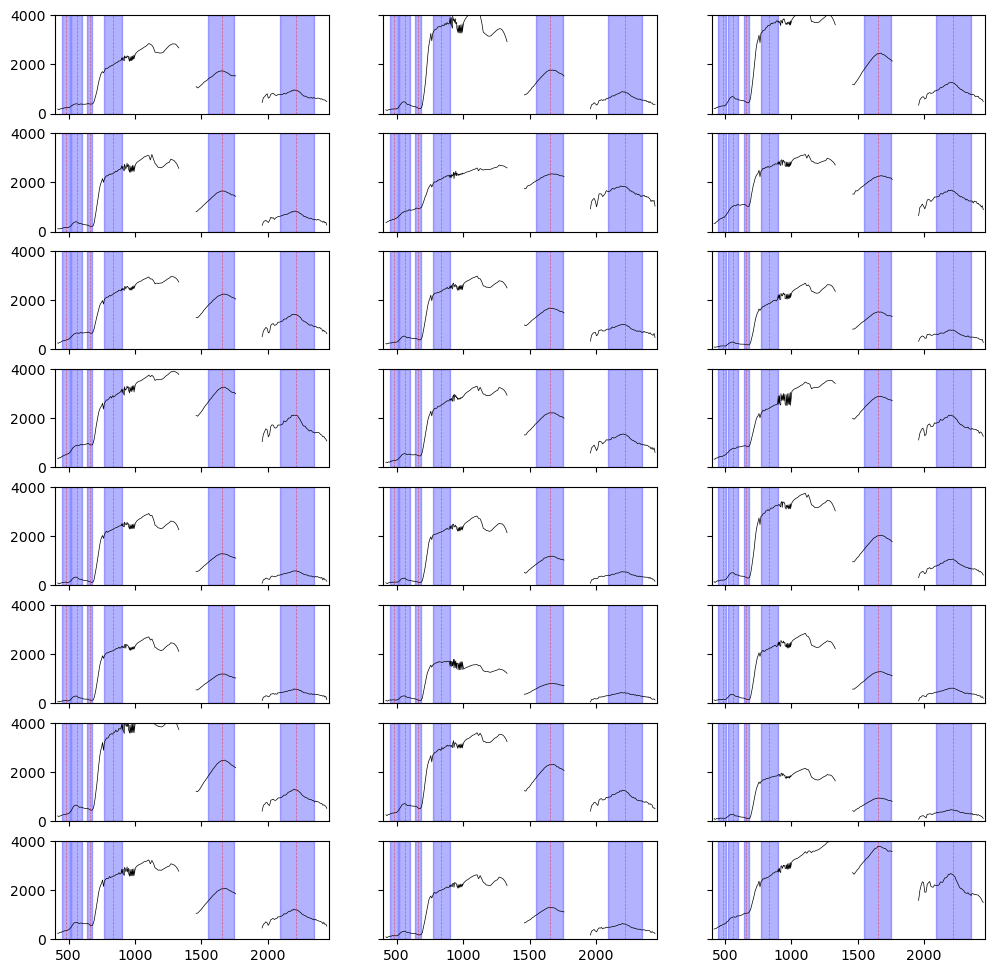

In [10]:
#grab a few random pixels and make a similar plot
#make sure the random pixels contain data, and aren't in the NaN region surrounding the tile
#(see show above)

def get_random_pix(image, num=24, seed=0):
    np.random.seed(0)
    random_x = list(np.random.randint(200, img.shape[1]-200, size=num))
    random_y = list(np.random.randint(200, img.shape[2]-200, size=num))

    df = gpd.GeoDataFrame()
    df["value"] = [img[:, x, y] for (x,y) in zip(random_x, random_y)]

    return df

gdf2 = get_random_pix(img)
plot_spectra(gdf2, 8, 3, show_bands=[13, 29, 46, 70, 152, 194])

In [11]:
#grab a lot more random pixels and get reflectivity in bands of interest

rando = get_random_pix(img, num=10000)

def get_refl_in_band(band, data):
    for_hist = []

    for row in data.iterrows():
        bandval = row[1]['value'][band]
        if bandval > 0:
            for_hist.append(bandval)
        else:
            #NaN = -32768
            for_hist.append(np.nan)

    return for_hist

#DON'T THINK THESE VARIABLES ARE NEEDED, JUST USE ARRAYS DIRECTLY?
#random pixels
rando_refl = {}
for band in [13, 29, 46, 70, 152, 194]:
    rando_refl[band] = get_refl_in_band(band, rando)

#random pixels with spectra shown above
gdf2_refl = {}
for band in [13, 29, 46, 70, 152, 194]:
    gdf2_refl[band] = get_refl_in_band(band, gdf2)

#lagoon pixels
pit_refl = {}
for band in [13, 29, 46, 70, 152, 194]:
    pit_refl[band] = get_refl_in_band(band, points)

CPU times: user 30.6 s, sys: 588 ms, total: 31.2 s
Wall time: 26.4 s


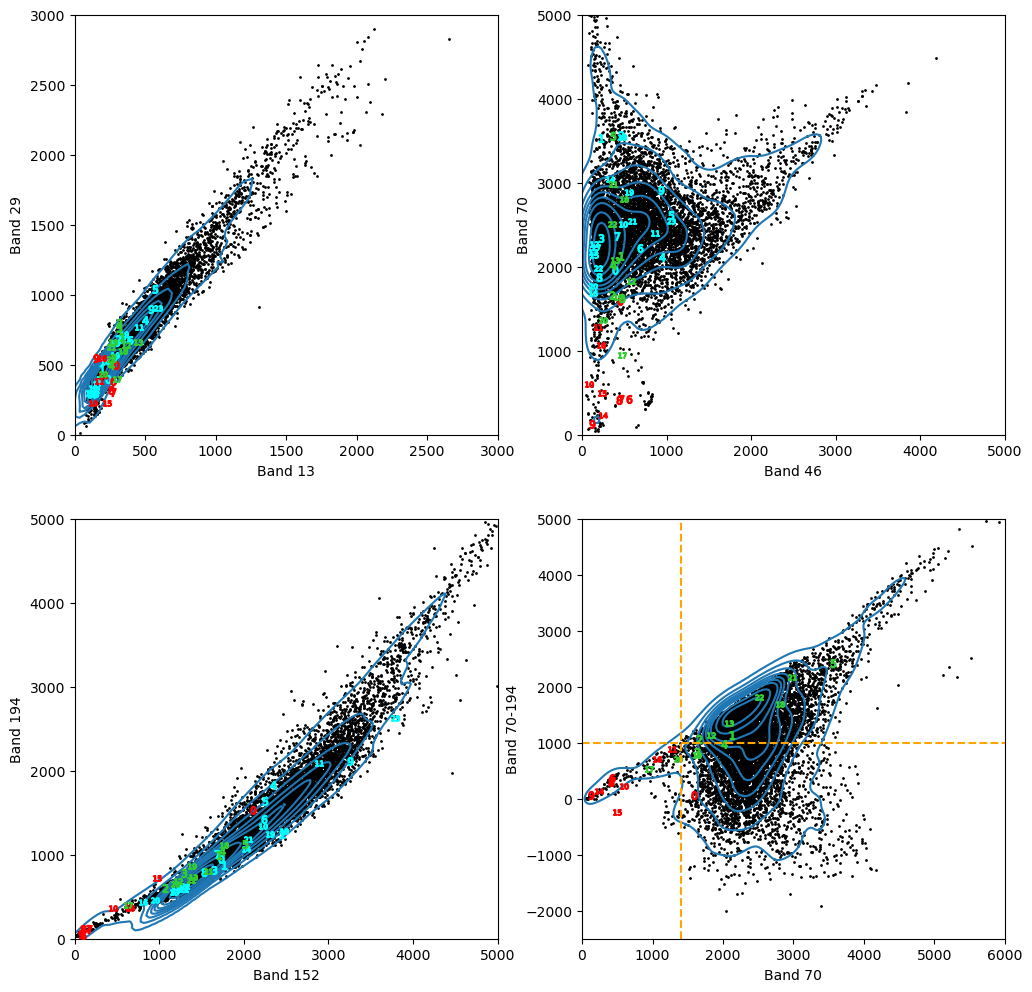

In [25]:
%%time
#make 3 color-color plots and a color-reflectivity plot

markers = [str(s) for s in points.index]
markers2 = [str(s) for s in gdf2.index]
_, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

for ax, bands, lim in zip([ax1, ax2, ax3], [[13, 29], [46, 70], [152, 194]], [3000, 5000, 5000]):
    ax.scatter(rando_refl[bands[0]], rando_refl[bands[1]], s=1, color='k', zorder=0)
    sns.kdeplot(x=rando_refl[bands[0]], y=rando_refl[bands[1]], ax=ax)
    for n in range(len(pit_refl[bands[0]])):
        if points.loc[n,'Area (m2)'] < 3600:
            color='limegreen' #pits with area < 2x2 EnMAP pixels
        else:
            color='red'
        ax.scatter(pit_refl[bands[0]][n], pit_refl[bands[1]][n], marker=f"${markers[n]}$", s=32, color=color, zorder=3)
    for n in range(len(gdf2_refl[13])): 
        ax.scatter(gdf2_refl[bands[0]][n], gdf2_refl[bands[1]][n], marker=f"${markers2[n]}$", s=32, color="cyan", zorder=2)
    ax.set_xlabel(f'Band {bands[0]}')
    ax.set_ylabel(f'Band {bands[1]}')
    ax.set_xlim(0, lim)
    ax.set_ylim(0, lim)


ax4.scatter(rando_refl[70], [x - y for (x, y) in zip(rando_refl[70], rando_refl[194])],\
            s=1, color='k', zorder=0)
sns.kdeplot(x=rando_refl[70], y=[x - y for (x, y) in zip(rando_refl[70], rando_refl[194])],\
            ax=ax4)
for n in range(len(pit_refl[70])):
    if points.loc[n,'Area (m2)'] < 3600:
        color='limegreen' #pits with area < 2x2 EnMAP pixels
    else:
        color='red'
    ax4.scatter(pit_refl[70][n], pit_refl[70][n] - pit_refl[194][n],\
                color=color, marker=f"${markers[n]}$", s=32, zorder=2)

ax4.axhline(1000, color='orange', ls='--')
ax4.axvline(1400, color='orange', ls='--')

ax4.set_xlabel('Band 70')
ax4.set_ylabel('Band 70-194')
_ = ax4.set_xlim(0, 6000)
_ = ax4.set_ylim(-2500, 5000)

plt.savefig('scatter_plots.png', dpi=400)

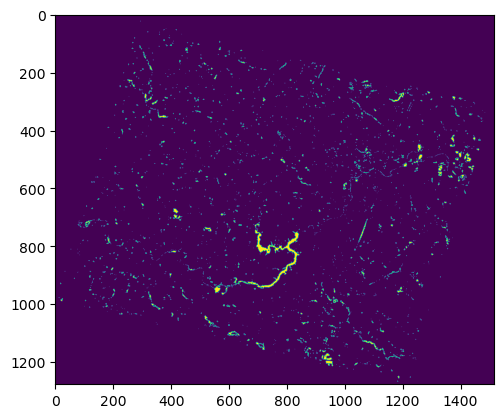

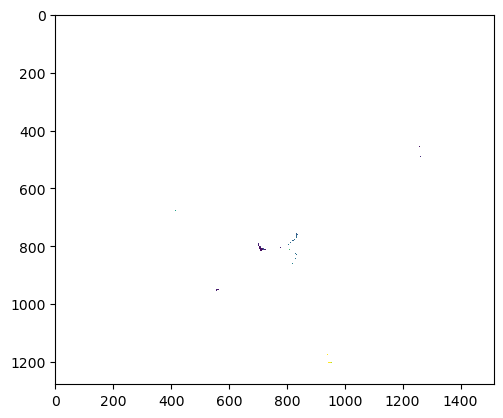

In [28]:
#Select all pixels from EnMAP data cube that lie to the left of the dashed line in the previous figure

#Boolean array showing which pixels meet the criteria
#final term excludes bad pixels
mask = (img[70, ...] - img[194] < 1000) & (img[70] < 1400) & (img[70] > 0) 
plt.imshow(mask)
plt.show()

selected = img.copy().astype(float)
#pixels that don't meet the criteria = NaN; others retain original spectra
selected[:, ~mask] = np.nan
plt.imshow(selected[70], vmin=0, vmax=1000)

with rasterio.open(path+'selected.tif', 'w', driver='GTiff', height=img.shape[1], width=img.shape[2],\
                            count=img.shape[0], dtype=masked.dtype, crs=src.crs, transform=src.transform) as dst:
    dst.write(selected)

In [89]:
%%time
#Now let's do that step where we remove very large features that are pieces of rivers etc.
#  - vectorise the numpy array ('selected')
#  - drop polygons > certain size
#    - the largest of my known pits is 23,000 m2, which is 5x5 EnMAP pixels
#    - let's use (6*30) * (6*30) = 32000 m2 as a preliminary limit
#  - rasterize
#  - convert to boolean mask
#  - use updated mask to remove 'large' areas from 'selected' array

polygons = []
values = []
for vec in shapes(mask.astype('int16'), transform=src.transform):
    polygons.append(shape(vec[0]))
    values.append(vec[1])
    gdf = gpd.GeoDataFrame(crs=src.crs, geometry=polygons)

gdf['Area (m2)'] = gdf.geometry.area
initial = gdf.shape[0]

gdf = gdf[gdf['Area (m2)'] < 32000]
filtered = gdf.shape[0]
print(f'Removed {initial - filtered} of {initial} features')

gdf.drop(columns=['Area (m2)'], inplace=True)
gdf['value'] = 1

#I suppose I need to re-rasterise this gdf and use it as a mask like in the last cell
geom = ((geom,value) for geom, value in zip(gdf.geometry, gdf.value))
small_mask = rasterize(geom, out_shape = mask.shape, fill = 0, out = None, transform = src.transform,\
                       all_touched = False, default_value = 1, dtype = None)
small_mask = np.array(small_mask, dtype=bool)

small = selected.copy().astype(float)
#pixels that don't meet the criteria = NaN; others retain original spectra
small[:, ~small_mask] = np.nan

#It would be helpful to write this out as a file and look at it in QGIS, but the files are large so I won't do that right now.
#(Should compress the tifs when writing, though)

Removed 125 of 2759 features
CPU times: user 17.8 s, sys: 13.1 s, total: 30.9 s
Wall time: 37.4 s


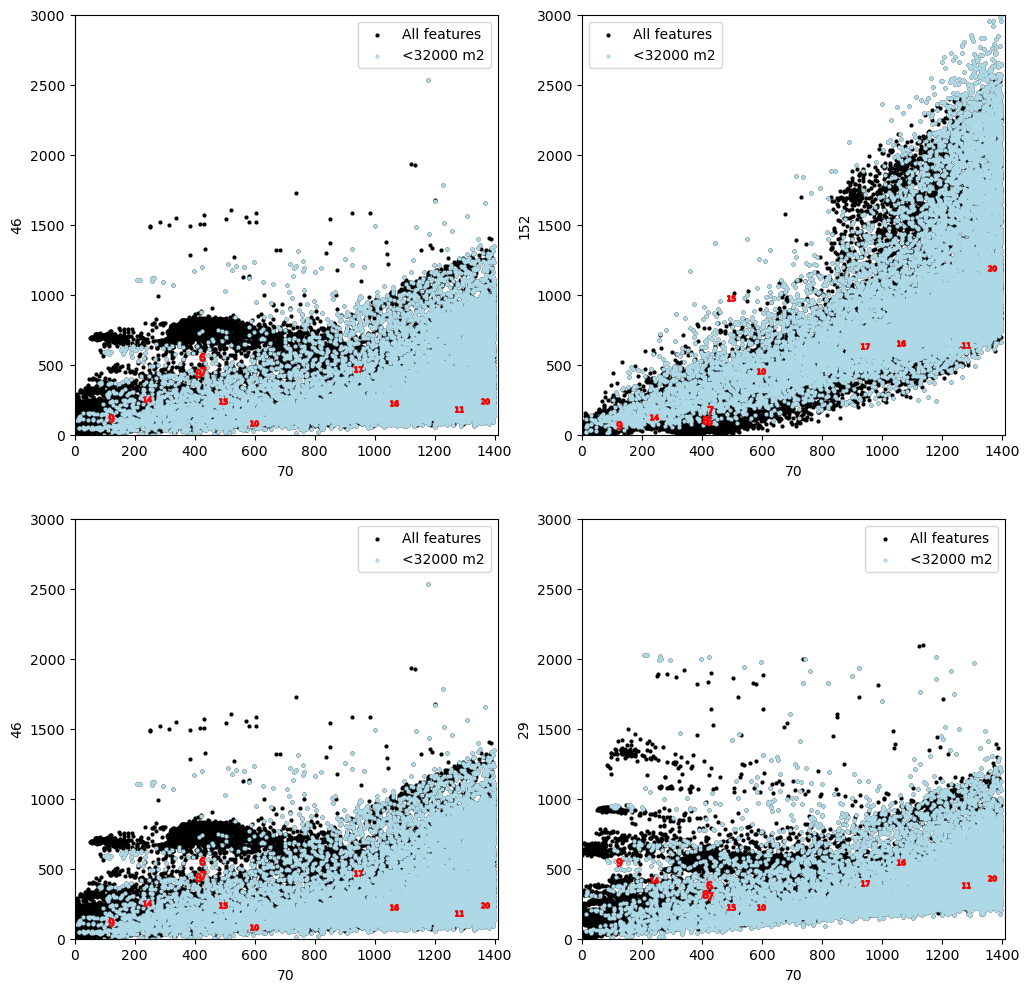

In [126]:
#Let's look at the selected pixels in some kind of color space
#Not sure whether I will do anything with it, but I do want to see how the plots look
#The pixels with relatively high 70 and 194 or 152 are probably ~soil. Might be
#feasible to remove them with another color cut/criterion without losing pits.
#It will also be interesting how the colors of the smaller pits change in higher-resolution data.
#Some of them are already on the frings of the main group, will they become more distinct?

_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

for ax, bands, lims in zip([ax1, ax2, ax3, ax4], [[70, 194], [70, 152], [70, 46], [70, 29]],\
                          [[1410, 3000], [1410, 3000], [1410, 3000], [1410, 3000]]):
    all = ax.scatter(selected[bands[0]], selected[bands[1]], s=4, color='k')
    small_only = ax.scatter(small[bands[0]], small[bands[1]], s=4, color='lightblue')
    for n in range(len(pit_refl[bands[0]])):
        ax.scatter(pit_refl[bands[0]][n], pit_refl[bands[1]][n], marker=f"${markers[n]}$", s=32, color='r', zorder=3)
    ax.set_xlim(0, lims[0])
    ax.set_ylim(0, lims[1])
    ax.set_xlabel(bands[0])
    ax.set_ylabel(bands[1])
    ax.legend((all, small_only), ('All features', '<32000 m2'))


In [95]:
#Now let's look at spectra of buildings (centroids of farm complexes)

barns = f'{path}manure_storage_structures/tile13_bldg_outlines.shp'
temp = gpd.read_file(barns).drop(columns=['id'])
bldgs = gpd.GeoDataFrame(geometry=temp['geometry'].centroid)

coord_list = [(x, y) for x, y in zip(bldgs["geometry"].x, bldgs["geometry"].y)]
bldgs["value"] = [x for x in src.sample(coord_list)]

,geometry,value
0,POINT (230629.648 3993180.796),"[1022, 1017, 1044, 1043, 1062, 1075, 1103, 111..."
1,POINT (234363.922 3990241.019),"[1047, 1057, 1059, 1029, 1083, 1067, 1092, 108..."
2,POINT (220787.097 3989911.100),"[1213, 1274, 1284, 1305, 1302, 1301, 1323, 136..."
3,POINT (221776.015 3988335.396),"[1244, 1239, 1241, 1282, 1260, 1286, 1301, 133..."
4,POINT (221970.503 3978174.018),"[1257, 1243, 1264, 1267, 1303, 1284, 1319, 133..."
5,POINT (226512.994 3975661.128),"[1096, 1088, 1117, 1135, 1148, 1167, 1185, 121..."
6,POINT (226507.508 3975566.070),"[772, 779, 811, 820, 857, 878, 895, 918, 930, ..."
7,POINT (233719.586 3980458.386),"[975, 971, 1026, 1011, 1051, 1067, 1082, 1101,..."
8,POINT (233944.638 3980403.120),"[1302, 1286, 1328, 1335, 1352, 1353, 1376, 139..."
9,POINT (234034.337 3980387.273),"[805, 806, 845, 845, 877, 880, 907, 927, 943, ..."


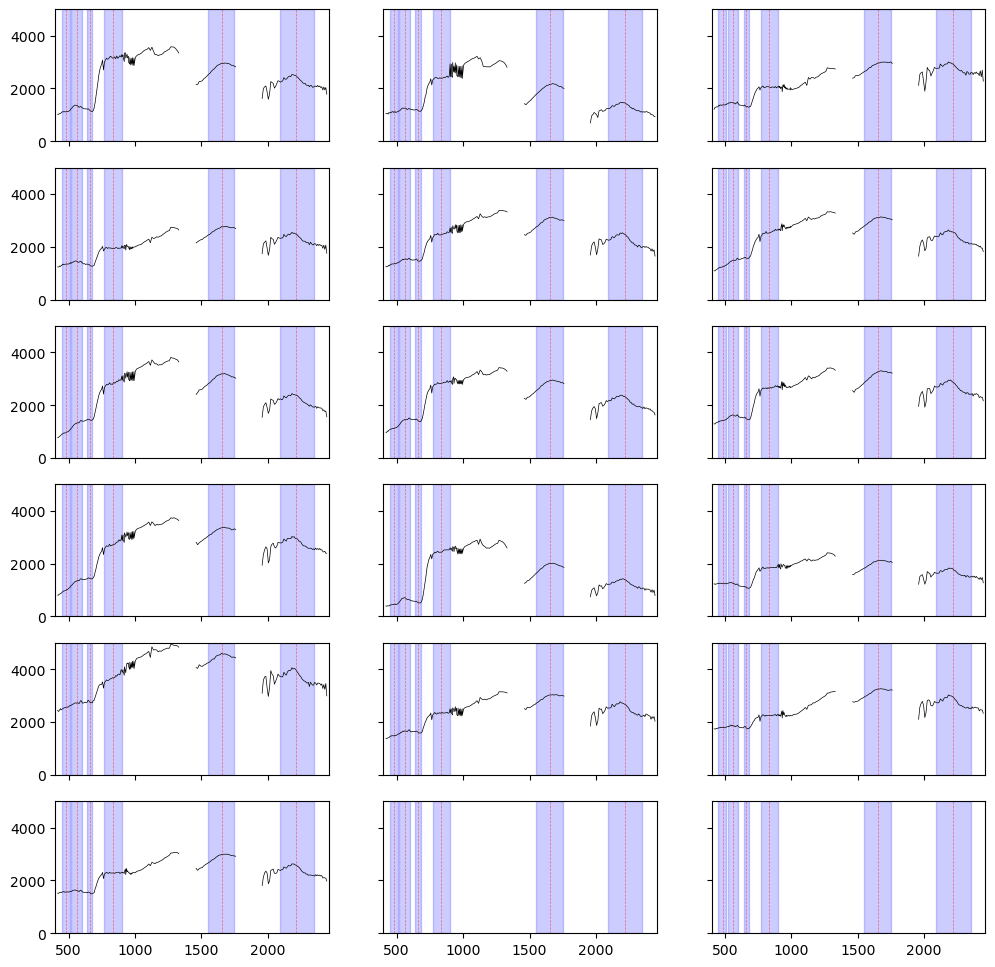

In [102]:
plot_spectra(bldgs, rows=6, cols=3, show_bands=[13, 29, 46, 70, 152, 194], ymax=5000)

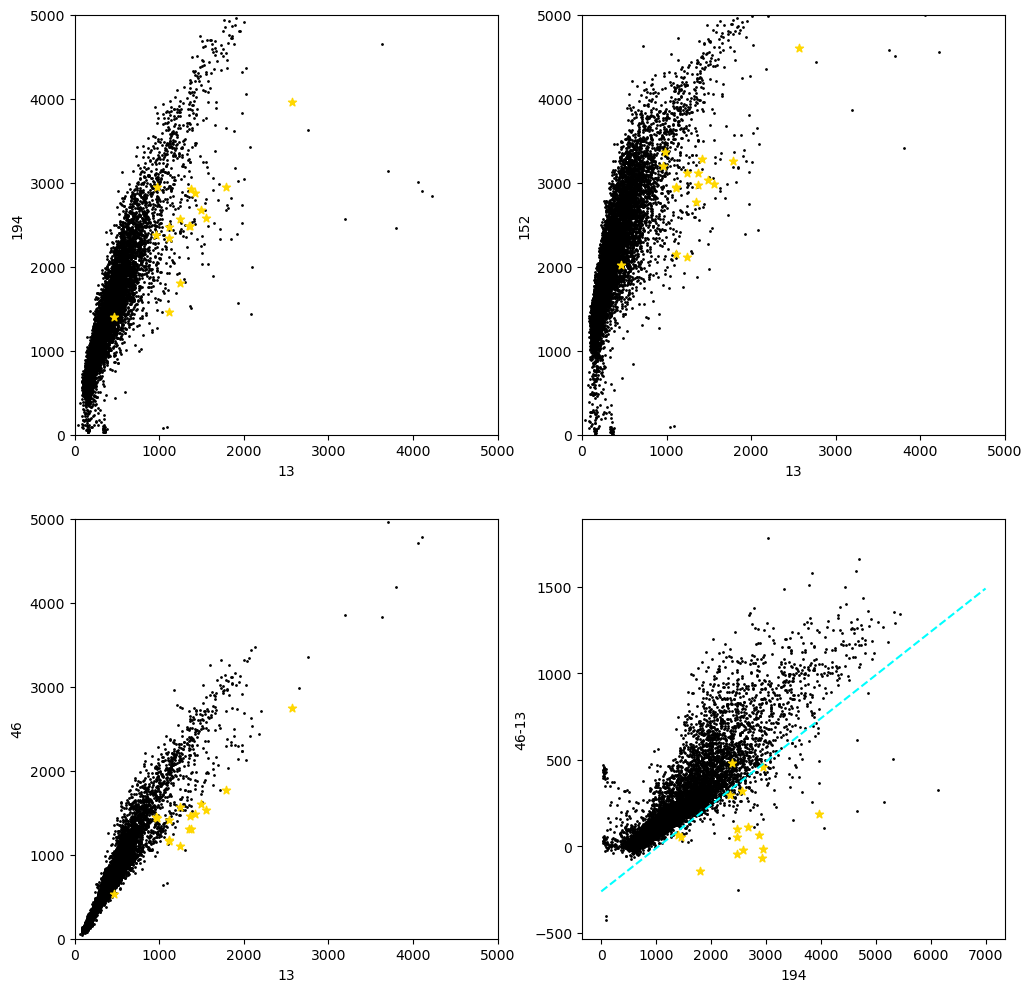

In [154]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

for ax, bands, lims in zip([ax1, ax2, ax3], [[13, 194], [13, 152], [13, 46]],\
                          [[5000, 5000], [5000, 5000], [5000, 5000]]):
    ax.scatter(rando_refl[bands[0]], rando_refl[bands[1]], s=1, color='k', zorder=0)
    for idx, row in bldgs.iterrows():
        ax.scatter(row['value'][bands[0]], row['value'][bands[1]], marker='*', color='gold')
    ax.set_xlim(0, lims[0])
    ax.set_ylim(0, lims[1])
    ax.set_xlabel(bands[0])
    ax.set_ylabel(bands[1])

ax4.scatter(rando_refl[194], [x - y for (x, y) in zip(rando_refl[46], rando_refl[13])],\
            s=1, color='k', zorder=0)
for idx, row in bldgs.iterrows():
    ax4.scatter(row['value'][194], row['value'][46] - row['value'][13], marker='*', color='gold')
ax4.set_xlabel('194')
ax4.set_ylabel('46-13')

#line of separation (just eyeballed)
x = np.linspace(0, 7000, 10)
y = 0.25*x - 260
_ = ax4.plot(x, y, color='cyan', ls='--')
#check
#for idx, row in bldgs.iterrows():
#    if 0.25*row['value'][194] - (row['value'][46] - row['value'][13]) > 260:
#        ax4.scatter(row['value'][194], row['value'][46] - row['value'][13], s=1, color='blue')

In [13]:
#Running PCA on the randomly-selected pixels

#Get data into correct format
tempdict = rando.to_dict()
arr = [] #np array?
for value in tempdict['value'].values():
    arr.append(list(value))
X = np.vstack(arr)

#Remove bands with refl < 0 (bad)
X = X[:,~np.all(X < 0, axis=0)]

#standardize (create z-score spectra)
X = StandardScaler().fit_transform(X)

#run the PCA
pca = PCA()

#pca.fit() to get properties such as explained_variance_ratio_
#properties = pca.fit(X)

#pca.fit_transform to get the n_components components for each spectrum
comps = pca.fit_transform(X)


In [ ]:
%%time
#Can I run PCA on the whole tile? And get an image out?

plt.imshow(img[50], vmin=0, vmax=1000)
plt.show()

#Just a little test snippet
snippet = img[:, 550:950, 300:800]
rasterio.plot.show(snippet[50], vmin=0, vmax=1000)
plt.show()
print(snippet.shape)

#Flatten to 2D as required by scikit-learn
X = np.array([features_2d.flatten() for features_2d in snippet]).T

#Remove "bad" bands
X = X[:,~np.all(X < 0, axis=0)]

#Standardize (create Z-score spectra)
X = StandardScaler().fit_transform(X)
print('here')
#Run PCA
pca = PCA()
comps = pca.fit_transform(X)
print('done')
#Return principal components array to original shape (minus "bad" bands)
comps = comps.T
comps = np.reshape(comps, (X.shape[1], snippet.shape[1], snippet.shape[2]))
plt.imshow(comps[2])

#Write principal components array to file
#First, we need to obtain the geo information for the snippet
win = rasterio.windows.Window(300, 550, 500, 400)
win_transform = src.window_transform(win)
print(win_transform)
with rasterio.open('/Users/rmason/Research/EnMAP/test.tif', 'w', driver='GTiff', height=comps.shape[1], width=comps.shape[2],\
                            count=comps.shape[0], dtype=comps.dtype, crs=src.crs, transform=win_transform) as dst:
    dst.write(comps)

In [ ]:
#src.close()